In [ ]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [1]:
import math
import os

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

/home/rudi/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


# Self-Generated Datasets

In [ ]:
def generate_normal_dataset(size, num_columns, mean, std_dev, output_path=None):
    """
    Generates a dataset with the specified parameters where each column
    contains integer values following a normal distribution.

    Parameters:
    - size (int): Number of rows in the dataset.
    - num_columns (int): Number of columns in the dataset.
    - mean (float): Mean of the normal distribution.
    - std_dev (float): Standard deviation of the normal distribution.
    - output_dir (str, optional): Directory to save the dataset in Parquet format. Defaults to None.

    Returns:
    - pd.DataFrame: Generated dataset as a pandas DataFrame.
    """
    # Generate random data for each column
    data = {
        f"d_{i}": np.random.normal(loc=mean, scale=std_dev, size=size).astype(int)
        for i in range(num_columns)
    }

    # Create DataFrame
    df = pd.DataFrame(data)

    # Save to output directory if specified
    if output_path:
        df.to_parquet(output_path, index=False)
        print(f"Dataset saved to {output_path}")

    return df


In [ ]:
df = generate_normal_dataset(size=100000, num_columns=3, mean=5000, std_dev=50, output_path="data/normal_3d_100k.parquet")

Dataset saved to data/normal_3d_100k.parquet


In [ ]:
df = pd.read_parquet("data/normal_3d_100k.parquet")

In [ ]:
df.describe()

NameError: name 'df' is not defined

## 6 Dimensions Dataset

In [76]:
def generate_bounded_normal(loc, scale, size, low, high):
    result = []
    while len(result) < size:
        samples = np.random.normal(loc=loc, scale=scale, size=size)
        valid_samples = samples[(samples >= low) & (samples <= high)]
        result.extend(valid_samples.astype(int))
    return np.array(result[:size])

In [77]:
def generate_fake_dataset(size, output_path=None):

    regions = [
        "Baden-Württemberg", "Bavaria", "Berlin", "Brandenburg", "Bremen", 
        "Hamburg", "Hesse", "Lower Saxony", "Mecklenburg-Vorpommern", 
        "North Rhine-Westphalia", "Rhineland-Palatinate", "Saarland", 
        "Saxony", "Saxony-Anhalt", "Schleswig-Holstein", "Thuringia"
    ]
    gender = ["m","f","d"]
    product_category = [chr(i) for i in range(97, 123)]

    p_product_category = np.random.zipf(1.5, len(product_category))
    p_product_category = p_product_category / np.sum(p_product_category)

    reference_dist = pd.read_parquet("data/reference_dist.parquet")

    ages_array = generate_bounded_normal(loc=35, scale=10, size=size, low=18, high=76)

    data = {
        "region": np.random.choice(regions, size=size, replace=True),
        "gender": np.random.choice(gender, size=size, replace=True, p=[0.48, 0.49, 0.03]),
        "category": np.random.choice(product_category, size=size, replace=True, p=p_product_category),
        "date": np.random.choice(reference_dist['date'], size=size, replace=True),
        "total": np.random.choice(reference_dist['total'], size=size, replace=True),
        "age": ages_array      
    }

    # Create DataFrame
    df = pd.DataFrame(data)

    # Save to output directory if specified
    if output_path:
        df.to_parquet(output_path, index=False)
        print(f"Dataset saved to {output_path}")

    return df


In [80]:
df = generate_fake_dataset(size=200000, output_path="data/paper_example_200k.parquet")

Dataset saved to data/paper_example_200k.parquet


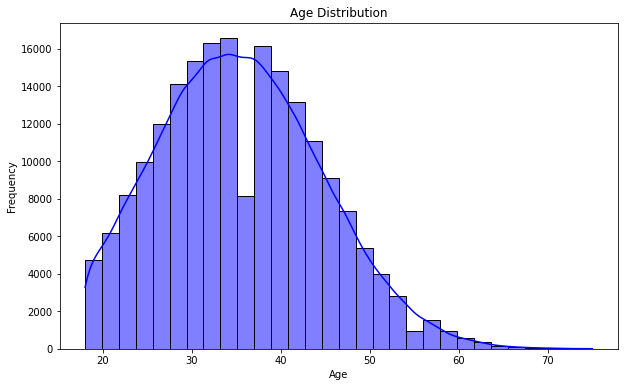

In [81]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Generate random ages with a normal distribution
ages_array = np.random.normal(loc=35, scale=10, size=1000).astype(int)

# Clip the ages to ensure they fall within the range of 18 to 76
ages_array = np.clip(ages_array, 18, 76)

,date,total
0,30,647
1,30,406
2,30,329
3,30,753
4,30,574
...,...,...
128970,61,517
128971,61,999
128972,61,690
128973,61,1199


# Kaggle

## E-Commerce Sales Dataset

In [4]:
df = pd.read_csv("data/raw/amazon_sale_report.csv", low_memory=False)
df.to_parquet("data/raw/amazon_sale_report.parquet", index=False)

In [5]:
df = pd.read_parquet("data/raw/amazon_sale_report.parquet")

In [11]:
df.columns

Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ',
       'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city',
       'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids',
       'B2B', 'fulfilled-by', 'Unnamed: 22'],
      dtype='object')

In [15]:
df_column_subset = df[['Date', 'Status',
       'Style', 'Category', 'Size',
       'Qty', 'Amount',
       'ship-state']].copy()

In [66]:
df_column_subset['total'] = df_column_subset['Amount'].fillna(0).astype(int)

In [67]:
df_column_subset['date'] = pd.to_datetime(df_column_subset['Date'], format='%m-%d-%y').rank(method='dense').astype(int) - 1

In [68]:
df_column_subset[['date', 'total']].to_parquet("data/raw/reference_dist.parquet", index=False)

In [58]:
df_column_subset.nunique()

Date            91
Status          13
Style         1377
Category         9
Size            11
Qty             10
Amount        1002
ship-state      69
dtype: int64